# Research data processing notebook

This notebook contains the code used to process the GtR data underlying the analysis of research activities in [Arloesiadur](http://www.arloesiadur.org) and, at the end, some code to produce visualisations for a working paper we presented at the 2017 Data for Policy conference. If you want to download the data used as an input, use the code [here](https://github.com/nestauk/gtr_analysis/tree/master/scripts)


**NOTE**

The code below is rough around the edges - apologies in advance. We will be refactoring, polishing and improving documentation in due course. Thanks for your patience!

### Inputs
* Project and funder tables

### Activities
* Load data
* Train model to predict missing labels

### Outputs
* Labelled datasets to be processed in the NLP notebook

## 1. Preamble

In [1]:
#Inline matplotlib output
%matplotlib inline

#Imports

#Numerical analysis
import os
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize

#Visualisation
import matplotlib.pyplot as plt
import networkx as nx

#Utilities
import json
import re
import itertools
from itertools import combinations
import pickle
from bs4 import BeautifulSoup
import datetime
import warnings

#Network analysis
import networkx as nx
import community

#NLP
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.matutils import corpus2dense
from gensim import corpora, models, similarities

#Classification
from sklearn.multiclass import OneVsRestClassifier
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.multiclass import LabelBinarizer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

#Clustering
from scipy.spatial.distance import squareform, pdist
from sklearn.cluster import AffinityPropagation, MeanShift, DBSCAN,AgglomerativeClustering
from sklearn.covariance import GraphLassoCV

#Paths
cwd = os.getcwd()

models_path = os.path.join(os.path.dirname(os.path.dirname(cwd)),'models')
ext_data = os.path.join(os.path.dirname(os.path.dirname(cwd)),'data/external')
int_data = os.path.join(os.path.dirname(os.path.dirname(cwd)),'data/interim')
proc_data = os.path.join(os.path.dirname(os.path.dirname(cwd)),'data/processed')
fig_path = os.path.join(os.path.dirname(os.path.dirname(cwd)),'reports/figures')

#Warnings etc
pd.options.mode.chained_assignment = None


with warnings.catch_warnings():
    [warnings.filterwarnings('ignore',category=x) for x in [DeprecationWarning,UserWarning, UndefinedMetricWarning]]
    
#Date for saving files 
tod = datetime.date.today()
today = "_".join([str(x) for x in [tod.year,tod.month,tod.day]])

/usr/local/lib/python3.5/site-packages/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


In [2]:
#Analytical functions

#######
#SNA functions
#######

def extract_network_from_corpus(label_corpus,edge_attr="None",stop_words=None):
    """
    Extracts a network object from a list or series where every observation is a list of co-ocurring observations
    (e.g. interacting agents, or co-occurring words). 
    In the network output, the labels are nodes and co-occurrences between them are edges. 
    Weight is number of co-occurrences. There is the option to consider additional edge attributes.

    Inputs:
    label_corpus: corpus of documents with label co-occurrence or node interaction.
    edge_attr: an edge attribute associated to the interaction. It defaults to the string none (which we use
        for control flow)
    stop_words: labels to remove (e.g. generic terms)
    
    Returns a networkx object.
    
    """
    label_pairs_container =[]
    
    #!!! TODO Using type to control flow feels a bit hacky.
    if type(edge_attr) != str:
        #Container for pairs of labels
        edge_attr_name = edge_attr.name
    
    #For each pair
    for i in range(len(label_corpus)):
    
    #List of tuples where every tuple is a combination of topics
        pairs = list(combinations(label_corpus[i],2))
    
    #Extract these as lists of dicts capturing connections between topics, and add those to the container.
    #NB we are sorting the tuples to make sure that we don't duplicate edges.
        if len(pairs)>0:
            cont = [{'e1':sorted(tup)[0],'e2':sorted(tup)[1]} for tup in pairs]
            
            #Give each edge its corresponding attribute (if we have one)
            if type(edge_attr) != str:
                for d in cont:
                    d.update({edge_attr_name: edge_attr[i]})

            label_pairs_container.append(cont)

    #Flatten dict list and turn into DF
    label_pairs_df = pd.DataFrame([ds for sublist in label_pairs_container for ds in sublist])
    
    #Extract weights (depends on edge_attr)
    if type(edge_attr) != str:
        label_edgelist = pd.DataFrame(label_pairs_df.groupby(['e1','e2',edge_attr_name]
                                                        ).size()).reset_index().sort_values(by=0,ascending=False)
    else:
        label_edgelist = pd.DataFrame(label_pairs_df.groupby(['e1','e2']
                                                        ).size()).reset_index().sort_values(by=0,ascending=False)
    
    label_edgelist.rename(columns={0:'weight'},inplace=True)
    
    #Remove stop-words
    if stop_words != None:
        has_ttm =  [x in stop_words or y in stop_words for x,y in zip(label_edgelist['e1'],label_edgelist['e2'])]
        label_edgelist = label_edgelist[-pd.Series(has_ttm)]
    
    #Create label graph
    if type(edge_attr) != str:
        label_graph = nx.from_pandas_dataframe(label_edgelist,'e1','e2',['weight',edge_attr_name])
    else:
        label_graph = nx.from_pandas_dataframe(label_edgelist,'e1','e2',['weight'])
    
    return(label_graph)    



######
#Text processing functions
######

def remove_rare_tokens(token_list,threshold=1):
    '''
    Takes a list where each element is a list of tokens, and remove those that only occur below the threshold
    in the whole dataset.
    
    '''
    
    tokens_flat = [x for el in token_list for x in el]
    tokens_count = [(x,tokens_flat.count(x)) for x in set(tokens_flat)]
    ones_to_drop = [x[0] for x in tokens_count if x[1]<threshold]
    
    
    tokens_clean = [[x for x in el if x not in ones_to_drop] for el in token_list]
    return(tokens_clean)
    

def clean_text(document):
    '''
    input = document, a string
    output = A list of tokens for analysis in gensim
    '''
    
    # To lowercase
    document= str(document)
    
    document = document.lower()
    
    # Remove html
    document = strip_fluff(document)
    
    return(document)

def strip_fluff(doc):
    s = strip_html(doc)
    s = strip_url(s)
    s = strip_newline(s)
    s = strip_nbsp(s)
    s = strip_quot(s)
    return s

def strip_html(doc):
    p = re.compile(r'<.*?>')
    return p.sub(' ', doc)

def strip_url(doc):
    return re.sub(r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))', '', doc)

def strip_newline(doc):
    doc = doc.replace('\n',' ')
    return doc.replace('\\n\\', ' ')

def strip_nbsp(doc):
    return doc.replace('&nbsp;', ' ')

def strip_quot(doc):
    return(doc.replace('&quot;',' '))

def strip_html_entity(doc):
    return doc.replace('&amp;')

def tokenise_text_descriptions(text_list):
    '''
    Takes a list where every element is a string with a description and returns a list where every element is
    a list of tokens. This involves...
    -Removing symbols
    -Removing line breaks
    -lowercasing
    -removing stopwords and leading lines
    -...
    '''
    
    
    pre_processed = [clean_text(x) for x in text_list]
    
    #Remove line breaks and lowercase
    #no_l_breaks = [re.sub(r'\\n',' ',x.lower()) for x in text_list]
    
    #Remove symbols
    no_symbols = [re.sub(r'[^\w]',' ',x) for x in pre_processed]
    no_numbers = [re.sub(' \d+',' ',x) for x in no_symbols]
    
    
    #Split on spaces
    split = [x.split(" ") for x in no_numbers]
    
    #Remove stopwords and fluff
    no_swords = [[x.strip() for x in el if x.strip() not in stop_w+['','\n','p','http','www',
                                                                   'li','ul','ol','nbsp']] for el in split]
    
    #We lemmatise the tokens here to avoid doing it for rare words we are going to throw away
    lemmatized = [[wnet.lemmatize(x) for x in el] for el in no_swords]

    
    #rares_out = Remove_rare_tokens(token_list=no_swords,threshold=threshold)
    
    return(lemmatized)

def pre_process_text(input_df):
    '''
    This function takes a df with researchj subjects, research topics and abstract keys and produces a clean,
    tokenised list ready for topic modelling.
    '''
        
    #Process subjects and tokens
    subject_tokens = remove_rare_tokens(input_df.subject_list,threshold=2)
    topic_tokens = remove_rare_tokens(input_df.topic_list, threshold=2)
    
    #Process abstracts
    abstract_tokens = tokenise_text_descriptions(input_df.abstract_texts)
    
    #Remove rare words from abstracts
    all_words = pd.Series([x for el in abstract_tokens for x in set(el)]).value_counts(ascending=False)

    rare_words = all_words.index[all_words<10]

    abstract_tokens_no_rare = [[x for x in el if x not in rare_words] for el in abstract_tokens]
    
    all_tokens = [x+y+z for x,y,z in zip(subject_tokens,topic_tokens,abstract_tokens_no_rare)]
    return(all_tokens)
    
######
#NLP functions
######
    
    
def lda_model(token_list,lda_pars={'alpha':'symmetric','eta':'symmetric','iterations':60,'passes':25},tops = 200):
    '''
    Returns an lda model of the corpus. For now, we stick to the standard parameters.
    
    '''
    
    dictionary = corpora.Dictionary(token_list)

    #Create corpus
    corpus = [dictionary.doc2bow(x) for x in token_list]

    #Initialise and fit tfidf model
    #tfidf = models.TfidfModel(corpus,normalize=True)
    #corpus_tfidf = tfidf[corpus]
    
    #
    trained_model = models.LdaModel(corpus,num_topics=tops,id2word=dictionary,
                                    passes=lda_pars['passes'],iterations=lda_pars['iterations'],
                                   alpha=lda_pars['alpha'],eta=lda_pars['eta'])

    
    return(trained_model)

#######
#ML Functions
#######

def visualise_model_outputs(model,X,Y,ax):
    '''
    This function takes a model, a feature set and the targets, and evaluates its performance, returning a 
    confusion matrix to be plotted in an ax
    '''
    
    preds = model.predict(X)

    conf_mat_list = []

    #For each column (i.e. discipline) we extract the predictions and actuals, and produce the confusion matrix.

    for num,i in enumerate(np.arange(len(lb.classes_))):
        #Extract predicted values
        predicted = preds[:,num]

        #Extract actual values
        actuals = Y[:,num]

        #Use both to obtain confusion matrix
        cf = confusion_matrix(actuals,predicted)
        conf_mat_list.append([lb.classes_[i],cf])
    
    #We want to plot the confusion matrix as a stacked bar chart.

    #We convert the elements in the container above into a df
    conf_mat_df = pd.DataFrame([{'disc':x[0],'tn':x[1][0,0],
                                'tp':x[1][1,1],'fp':x[1][0,1],
                                'fn':x[1][1,0]} for x in conf_mat_list]).set_index('disc')

    #We normalise.
    conf_df_norm = 100*conf_mat_df.apply(lambda x: x/x.sum(),axis=1)

    #Plot the confusion matrices.

    #fig,ax = plt.subplots(1,figsize=(7,5))

    conf_df_norm.plot.bar(stacked=True,ax=ax)

    ax.set_ylim(0,140)

    ax.set_title('Performance of label predictions by discipline')
    
def predict_unlabelled(model,feat,df_to_label,thres=0.75):
    '''
    Input: A model and an unlabelled set.
    Returns the labelled dataset
    
    
    '''

    #Extract labels
    predicted_labels = pd.DataFrame(model.predict_proba(feat),columns=lb.classes_).reset_index(drop=True)
    #labels = model.predict_proba(feat)
    
    #Produce dataframe
    dataset_to_label = df_to_label.copy()
    dataset_to_label.reset_index(drop=True,inplace=True)
    
    dataset_to_label['topic_comm'] = [predicted_labels.ix[i,:].argmax() if predicted_labels.ix[i,:].max()>thres else "Unlabelled" for 
                                                    i in np.arange(len(predicted_labels))]
    
    #return(projects_no_subject)
    return([predicted_labels,dataset_to_label])

######
#Output checking and final processing (including topic clustering)
######

def obtain_topic_ranking(disc,disc_df):
    '''
    
    This function takes a discipline and a discipline df and returns a df where one column is the topic
    and another is the number of projects where it appears.
    
    '''
    
    #Create binary df where cells = 1 if topic present in a project
    has_topic_df = disc_df.applymap(lambda x: 1 if x>0 else 0)
    
    #Total topics with project
    topic_sums = has_topic_df.sum(axis=0)
    
    #Generate output
    out_df = pd.DataFrame(topic_sums.reset_index(drop=False))
    
    #Naming the disciplines
    out_df['disc'] = disc
    out_df.rename(columns={0:'n_projects'},inplace=True)
    
    #Reorder columns
    out_df = out_df.iloc[:,[2,0,1]]
    
    #Output
    return(out_df.sort_values('n_projects',ascending=False))

def get_tops(series,top):
    '''
    This function returns the indices with highest 'top' values for a series
    '''
    sorted_s = series.sort_values(ascending=False)
    
    out = "_".join([x for x in sorted_s.index[:top]])
    return(out)

def spot_check_topics(df,n=5,topic_prefix='tm',top=5):
    '''
    Generates the top 5 topics for a random set of projects
    
    '''
    
    #Extract the ids
    ids = np.random.randint(0,len(df),size=n)
    
    selected_projects = df.ix[[x in ids for x in df.index],:].reset_index(drop=True)
    
    selected_meta = selected_projects[
        [x for x in selected_projects.columns if x.split("_")[0]!=topic_prefix]]
    selected_topics = selected_projects[[x for x in selected_projects.columns if x.split("_")[0]==topic_prefix]]
    
    top_topics = selected_topics.apply(lambda x: get_tops(x,top),axis=1)
    
    #names = top_topics.apply(lambda x: extract_top_names(x),axis=1)
    #names = selected_topics.idxmax(axis=1)
    
    results = pd.concat([selected_meta[['abstract_texts','topic_comm']],top_topics],axis=1)
    
    return(results)


def clusters_df(topics,labels,disc):
    '''
    This function creates a lookup between topic names and the labels generated by the clustering analysis.
    
    '''
    #Create df with the topic names and the labels
    result = pd.concat([pd.Series(selected),pd.Series(labels)],axis=1)
    
    #Sort values
    result = result.sort_values(1)
    
    #Add a 'discipline' label to facilitate visualisation
    result['disc'] = disc
    return(result)


## 2. Load data

In [3]:
#I. Load projects
projects = pd.read_csv(ext_data+'/gtr_update/projects_gtr.csv')

#Select relevant columns and subset
rel_vars = ['pkey','abstract_texts','grant_cats','href','identifiers',
            'lead_org_dpts','links','research_subjects','research_topics','status']

#Subset relevant variables
projects = projects[rel_vars]

#Extract the json elements form their 1 element-dicts
#NB as part of this we need to parse the jsons

projects['research_subjects'] = projects[
    'research_subjects'].map(lambda x: json.loads(x)['researchSubject'])

projects['research_topics'] = projects[
    'research_topics'].map(lambda x: json.loads(x)['researchTopic'])

In [4]:
#2. Load funds and orgs
#NB there are a couple of important variables missing from here: start date for the project and funding amounts
#They are in the funding df. We get them out.

#Load data
#Funds
funds = pd.read_csv(ext_data+'/gtr_update/funds_gtr.csv')

#Organisations
orgs = pd.read_csv(ext_data+'/gtr_update/organisations_gtr.csv')

#Each record in the funds df has two links, one to the funder and another to the project funded. We can match on
    #the second
#Create the id variable
funds['project_id'] = [str(json.loads(x)['link'][1]['href']) for x in funds.links]
funds['funder_id'] = [str(json.loads(x)['link'][0]['href']) for x in funds.links]

#And merge
projects_funds = pd.merge(projects,funds[['value_pounds','start','end','project_id','funder_id']],
                               left_on='href',right_on='project_id',how='inner')

#Also merge the funder information
projects_all = pd.merge(projects_funds,orgs[['href','name']],left_on='funder_id',right_on='href',
                          how='left')
projects_all.rename(columns={'name':'funder_name'},inplace=True)

#projects_all contains most of the information that we want
projects_all.ix[:2,:]

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:28: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


,pkey,abstract_texts,grant_cats,href_x,identifiers,lead_org_dpts,links,research_subjects,research_topics,status,value_pounds,start,end,project_id,funder_id,href_y,funder_name
0,1,While the DNA in our cells contains the inform...,Research Grant,http://gtr.rcuk.ac.uk:80/gtr/api/projects/B158...,"{""identifier"": [{""type"": ""RCUK"", ""value"": ""BB/...",Sir William Dunn Sch of Pathology,"{""link"": [{""rel"": ""PI_PER"", ""href"": ""http://gt...",[],[],Closed,303293,2008-02-01 00:00:00,NaN,http://gtr.rcuk.ac.uk:80/gtr/api/projects/B158...,http://gtr.rcuk.ac.uk:80/gtr/api/organisations...,http://gtr.rcuk.ac.uk:80/gtr/api/organisations...,BBSRC
1,2,"Insects are amongst the most diverse, successf...",Research Grant,http://gtr.rcuk.ac.uk:80/gtr/api/projects/B203...,"{""identifier"": [{""type"": ""RCUK"", ""value"": ""BB/...",Institute of Membrane & Systems Biology,"{""link"": [{""rel"": ""PI_PER"", ""href"": ""http://gt...",[],[],Closed,356926,2012-04-02 00:00:00,NaN,http://gtr.rcuk.ac.uk:80/gtr/api/projects/B203...,http://gtr.rcuk.ac.uk:80/gtr/api/organisations...,http://gtr.rcuk.ac.uk:80/gtr/api/organisations...,BBSRC
2,3,Doctoral Training Partnerships: a range of pos...,Training Grant,http://gtr.rcuk.ac.uk:80/gtr/api/projects/B34F...,"{""identifier"": [{""type"": ""RCUK"", ""value"": ""BB/...",Crop Genetics,"{""link"": [{""rel"": ""TGH_PER"", ""href"": ""http://g...",[],[],Active,95042,2015-10-01 00:00:00,NaN,http://gtr.rcuk.ac.uk:80/gtr/api/projects/B34F...,http://gtr.rcuk.ac.uk:80/gtr/api/organisations...,http://gtr.rcuk.ac.uk:80/gtr/api/organisations...,BBSRC


In [5]:
print(len(set(projects_all.project_id)))

projects_all.grant_cats.value_counts()

72592


Research Grant                                    41141
Training Grant                                     5917
Fellowship                                         4915
Innovation Voucher                                 3253
Studentship                                        3044
Collaborative Research & Development               2925
Intramural                                         2774
Feasibility Study                                  2308
Knowledge Transfer Partnership                     1628
Smart - Proof of Concept                            805
Smart - Development of Prototype                    734
Small Business Research Initiative                  716
Smart - Proof of Market                             635
European                                            481
Business, Innovation & Skills Financed              381
Other Grant                                         212
SME Support                                         148
Fast Track                                      

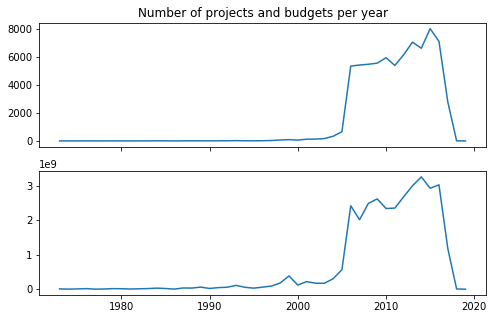

In [6]:
#What's the distribution of years and the amounts funded?

#NB here we convert strings to dates in order to extract years
projects_all['start_year'] = [datetime.datetime.strptime(x.split(" ")[0],"%Y-%m-%d").year for x in projects_all.start]

budgets_per_year = projects_all.groupby('start_year')['value_pounds'].aggregate([np.sum,len])

fig, ax = plt.subplots(2,figsize=(8,5),sharex=True)

ax[0].plot(budgets_per_year['len'])
ax[1].plot(budgets_per_year['sum'])

ax[0].set_title('Number of projects and budgets per year')

#We only start getting data around 2005

In [7]:
#Load lookup tables that will be used later

#Organisation-LAD lookup
org_geo = pd.read_pickle(ext_data+"/lut.p")
org_geo.reset_index(inplace=True,drop=True)

#Identify Welsh orgs
org_geo['is_wales'] = [x[0]=='W' for x in org_geo.lad]

#Give the lads names
lad_names = pd.read_csv(ext_data+'/lad13_country_lu.csv')

#Merge with org_lad
org_geo = pd.merge(org_geo,lad_names[['LAD13CD','LAD13NM']],left_on='lad',right_on='LAD13CD')

## 3. Community detection to identify disciplines

In [8]:
#Focus on academic projects where we have research topic / subject information

#These are in the Research Grant and Fellowship category
project_acad = projects_all[[i in ['Research Grant','Fellowship'] for
                                                 i in projects_all.grant_cats]]
        
#Only consider projects with subject data (drop nas and projects without subjects)
project_subj = project_acad[project_acad.research_subjects.notnull()]
project_subj = project_acad[[len(i)>0 for i in
                                             project_acad.research_topics]]

#How many are there?

#Extract research subjects and research topics.
project_subj['subject_list'] = [[i['text'] for i in sublist] for sublist in 
                                       project_subj['research_subjects']]
project_subj['topic_list'] = [[i['text'] for i in sublist] for sublist in 
                                       project_subj['research_topics']]

In [9]:
print(len(set(project_subj.project_id)))

project_subj.grant_cats.value_counts()/len(project_subj)


np.sum(project_subj.start_year>=2006)/len(project_subj)

33373


0.99889131932999731

In [176]:
len(projects_all.loc[[x in ['Research Grant','Fellowship'] for x in projects_all.grant_cats ],:])

46056

In [66]:
#Extract network and communities
project_subj.reset_index(drop=False,inplace=True)

gtr_topic_network = extract_network_from_corpus(project_subj.topic_list,
                                            stop_words="Research approaches")

#Community detection
topic_allocation = community.best_partition(gtr_topic_network,resolution=0.8)

#Print topic - community allocation
eyeball_topics = [[x,y] for x,y in zip(topic_allocation.keys(),topic_allocation.values())]
sorted(eyeball_topics,key=lambda x:x[1],reverse=False)

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:64: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


[['Ageing: chemistry/biochemistry', 0],
 ['Interaction with organisms', 0],
 ['Animal Diseases', 0],
 ['Animal organisms', 0],
 ['Recombination', 0],
 ['Gene therapy', 0],
 ['Bioreactors', 0],
 ['Protein folding / misfolding', 0],
 ['Genome organisation', 0],
 ['Biochemistry & physiology', 0],
 ['Gene action & regulation', 0],
 ['Food structure/composition', 0],
 ['Stem cell biology', 0],
 ['Glycomics', 0],
 ['Macro-molecular delivery', 0],
 ['Animal reproduction', 0],
 ['Biochemical engineering', 0],
 ['Novel industrial products', 0],
 ['Cells', 0],
 ['Livestock production', 0],
 ['Systems neuroscience', 0],
 ['Plant reproductive biology', 0],
 ['Transcriptomics', 0],
 ['Cell cycle', 0],
 ['Animal Welfare', 0],
 ['Responses to environment', 0],
 ['Structural Biology', 0],
 ['Extremophiles', 0],
 ['Bioinformatics', 0],
 ['Metabolomics / Metabonomics', 0],
 ['3Rs', 0],
 ['Multiprotein complexes', 0],
 ['Biophysics', 0],
 ['Functional genomics', 0],
 ['Crop protection', 0],
 ['Crop scien

In [32]:
#The community objects are dicts where keys are subjects or topics, and values their communities
#Use this group dict to relabel variables
grouped_topics_dict = {5:"Social Sciences",
                      3:"Environmental Sciences",
                      0:"Life Sciences",
                      2:"Arts and Humanities",
                      1:"Physics",
                      6:"Mathematics and Computing",
                      4:"Engineering and Technology"}

#Use the dict to convert topics into subjects
project_subj['topic_comm_list'] = [[grouped_topics_dict[topic_allocation[x]] for x in el] for
                                            el in project_subj.topic_list]

#Choose the biggest one
max_disc = [sorted([(x,el.count(x)) for x in set(el)],
                   key=lambda x: x[1],reverse=True) for el in project_subj['topic_comm_list']]

#We allocate projects randomly to the community at the top
alloc = [x[0][0] if len(x)==1 else x[0][0] if len(x)>1 and x[0][1]>x[1][1] else 
         x[np.random.binomial(1,0.5)][0] for x in max_disc]

project_subj['topic_comm'] = alloc

#Print the counts per discipline
[(y, alloc.count(y)) for y in set(alloc)]

[('Physics', 2189),
 ('Life Sciences', 3381),
 ('Social Sciences', 4874),
 ('Engineering and Technology', 7762),
 ('Mathematics and Computing', 4829),
 ('Arts and Humanities', 4951),
 ('Environmental Sciences', 5387)]

In [33]:
#Who funds what?
pd.crosstab(project_subj.topic_comm,project_subj.funder_name)

#Makes sense

funder_name,AHRC,BBSRC,EPSRC,ESRC,NERC,STFC
topic_comm,,,,,,
Arts and Humanities,4187,7,41,603,111,2
Engineering and Technology,8,88,7397,26,133,110
Environmental Sciences,64,102,80,18,5089,34
Life Sciences,7,2894,298,27,143,12
Mathematics and Computing,40,41,4649,44,28,27
Physics,0,0,12,1,19,2157
Social Sciences,238,29,33,4550,22,2


In [53]:
nx.write_graphml(gtr_topic_network,proc_data+'/topic_network.graphml')

In [34]:
#TO_MOVE - some checks of the classifications

def extract_edge_cases(comm,rc,df=project_subj):
    '''
    This function extracts edge cases from our labelling (e.g. 'Arts and Humanities projects funded
    by STFC'or 'Mathematics and Computing projects funded by AHRC')
    
    '''
    
    my_dfs =df.ix[(df.topic_comm==comm) & (df.funder_name==rc),:]
    
    
    my_dfs_vals = [[x,y] for x,y in zip(my_dfs.abstract_texts,my_dfs.topic_list)]
    return(my_dfs_vals)                   

In [14]:
comps_ahrc = extract_edge_cases('Mathematics and Computing','AHRC')

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


## 4. Exploratory data analysis

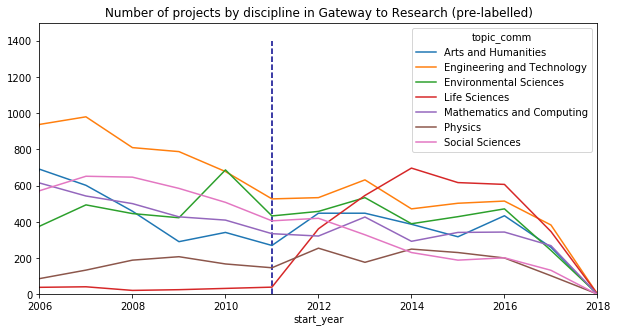

In [35]:
#Time series analysis suggests something quite strange with Life Sciences
times = pd.crosstab(project_subj.topic_comm,project_subj.start_year).T

fig,ax = plt.subplots(1,figsize=(10,5))

times.plot(ax=ax)

ax.set_ylim(0,1500)
ax.set_xlim(2006,2018)
ax.vlines(2011,ymin=0,ymax=1400,linestyles='dashed',colors='darkblue')
ax.set_title('Number of projects by discipline in Gateway to Research (pre-labelled)')


plt.savefig('/Users/jmateosgarcia/Desktop/writes/manchester_presentation/pre_labelled.pdf')


In [36]:
#We go back to the academic df we created before. What projects are there, and why?

ids_no_subject = set(project_acad.project_id) - set(project_subj.project_id)

project_no_subj = project_acad.ix[[x in ids_no_subject for x in project_acad.project_id],:]

#Projects in the life sciences only started to receive subjects info from 2011.

#MRC doesn't use research subjects or topics in its labelling.
project_no_subj.funder_name.value_counts()

#There is also a significant number of EPSRC and STFC projects with no research subject data

MRC      5962
BBSRC    4040
EPSRC    1046
STFC      707
AHRC      308
NERC      286
ESRC      177
NC3Rs     157
Name: funder_name, dtype: int64

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  app.launch_new_instance()


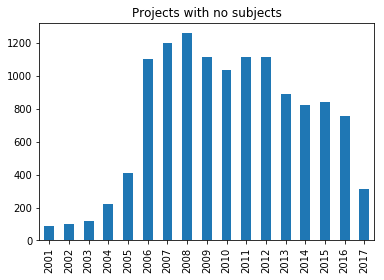

In [37]:
#What are the trends in non-labelling?
no_subject_counts = project_no_subj.start_year.value_counts().reset_index(drop=False).sort_values('index')
no_subject_counts = no_subject_counts.ix[no_subject_counts['index']>2000,:]

ax = no_subject_counts['start_year'].plot.bar()
ax.set_xticklabels(list(no_subject_counts['index']))
ax.set_title('Projects with no subjects')

#The decline in 2012 is probably caused by the beginning of labelling by BSRC. 
#The projects that remain unlabelled are probably the MSRC ones.



## 5. Classify unlabelled projects

In [38]:
#First step: unlabelled projects funded by Medical Sciences RC are treated as 'medical sciences'.

medical = project_no_subj.ix[project_no_subj.funder_name=='MRC',:]
medical['topic_comm'] = 'Medical Science'

#Concatenate them
projects_labelled = pd.concat([project_subj,medical])

#And create an unlabelled dataset where we want to predict the disciplines ('topic_comm')
#These are all projects with no subject with the exception of the MRC projects (which we just labelled)

projects_to_label = project_no_subj.ix[project_no_subj.funder_name!='MRC',:]


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  app.launch_new_instance()


In [39]:
#Tokenise abstract texts and remove rare words

#Stopwords
stop_w = list(set(stopwords.words('english')))
wnet = WordNetLemmatizer()

#Extract tokens from abstracts
#This is super-slow. How could I speed it up?
abstract_tokens = tokenise_text_descriptions(projects_labelled.abstract_texts)

#Identify and remove rare words (less than 10 occurrences)
all_words = pd.Series([x for el in abstract_tokens for x in set(el)]).value_counts(ascending=False)
rare_words = all_words.index[all_words<10]

abstract_tokens = [[x for x in el if x not in rare_words] for el in abstract_tokens]

#Create the dictionary
dictionary = corpora.Dictionary(abstract_tokens)

#Create now corpus
corpus = [dictionary.doc2bow(x) for x in abstract_tokens]

#Initialise and fit tfidf model
tfidf = models.TfidfModel(corpus,normalize=True)
corpus_tfidf = tfidf[corpus]

In [40]:
#Initialise label binariser and transform the target variables (Y) into an array of dimensions docs x labels
#Initialise
lb =LabelBinarizer()
#Binarise
Y = lb.fit_transform(projects_labelled.topic_comm)

#Identify number of tokens in the corpus (this is an input into the function we use to convert 
#the corpus into a dense np array below)
ids = [x for x in dictionary.token2id.values()]

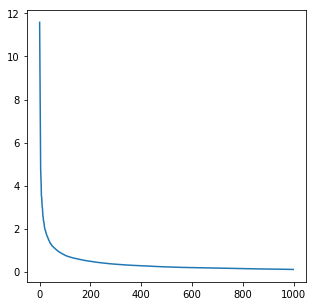

In [41]:
#Convert the corpus into a dense array of predictors
X = corpus2dense(corpus,num_terms=np.max(ids)+1)

#This has to be transposed
X = X.T

#We currently almost 20,000 features. We do some dimensionality reduction with PCAs.
#Some dimensionality reduction
pca = PCA(n_components=1000)
pca.fit(X)

#Most of the variance is explained by a small number of components
fig,ax = plt.subplots(1,figsize=(5,5))

ax.plot(pca.explained_variance_)

In [42]:
#Dimensionality reduce X
X_red = pca.transform(X)

#create funder ID 
lb_bin_funder = LabelBinarizer()
X_fund = lb_bin_funder.fit_transform(list(projects_labelled.funder_name))

#Combine funder and text features to create the feature set we will work with.
X = np.concatenate((X_red,X_fund),axis=1)

In [43]:
#Do cross-validation of a logistic and random forests model

#Scorer
scorer = make_scorer(precision_score,average='macro')

#Set up the estimators
log_clf = OneVsRestClassifier(LogisticRegression(verbose=True))
rf_clf = OneVsRestClassifier(RandomForestClassifier(verbose=True))

#Run and fit the models
#topic_clf_grid_results = [GridSearchCV(x[0],param_grid=x[1],scoring=scorer,cv=3).fit(X,Y) for x in [log_bunch,rf_bunch]]
#%time model_fit = [cross_val_score(x,X,Y,scoring=scorer,cv=3) for x in [log_clf,log_clf]]

log_clf.fit(X,Y)
rf_clf.fit(X,Y)

#fit_models = [x.fit(X,Y) for x in [log_clf,rf_clf]]

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.8s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   13.2s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.9s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   20.2s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   15.4s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    9.8s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   10.4s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.6s finished


OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=True, warm_start=False),
          n_jobs=1)

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


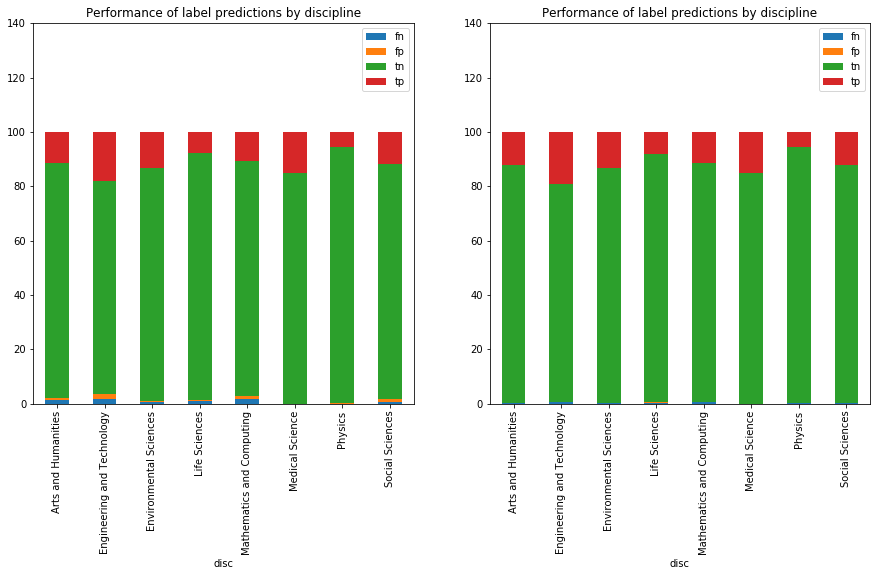

In [44]:
fig,(ax1,ax2)=plt.subplots(ncols=2,figsize=(15,7))
visualise_model_outputs(log_clf,X,Y,ax1)
visualise_model_outputs(rf_clf,X,Y,ax2)

Both models perform well. The random forests are better

### Prediction

In [45]:
#Pre-process unlabelled data

#Tokenise abstracts in the unlabelled dataset
abstract_tokenised_unlabelled = tokenise_text_descriptions(projects_to_label.abstract_texts)

#Then convert to corpus using the same dictionary we fit for the labelled corpus
corpus_unlabelled = [dictionary.doc2bow(x) for x in abstract_tokenised_unlabelled]

#Convert to dense numpy matrix and fit.
X_unl = corpus2dense(corpus_unlabelled,num_terms=np.max(ids)+1)
X_unl = X_unl.T

#Dimensionality reduction
X_red_unl = pca.transform(X_unl)

#Create feature set unlabelled

#We drop one of the classes in the binariser (NC3 didn't appear in the training set)
#select = [0,1,2,3,4,6,7]

X_unl_fund = lb_bin_funder.fit_transform(list(projects_to_label.funder_name))

X_unl = np.concatenate((X_red_unl,X_unl_fund),axis=1)

In [46]:
#Prediction
labels_rf = predict_unlabelled(rf_clf,X_unl,projects_to_label,thres=0.3)

labelled_df = labels_rf[1]

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:292: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [47]:
#This list allows us to check some of the project labels
random_check = []

for i in set(labelled_df['topic_comm']):
    my_set = labelled_df.ix[labelled_df['topic_comm']==i,:].reset_index(drop=False)
    
    project_sel = np.random.randint(0,len(my_set),2)
    
    abstracts = list(my_set.ix[project_sel,'abstract_texts'])
    random_check.append([i,abstracts])

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [48]:
labelled_df['topic_comm'].value_counts()

Life Sciences                 3657
Engineering and Technology     933
Physics                        504
Unlabelled                     464
Environmental Sciences         346
Arts and Humanities            326
Medical Science                184
Social Sciences                158
Mathematics and Computing      149
Name: topic_comm, dtype: int64

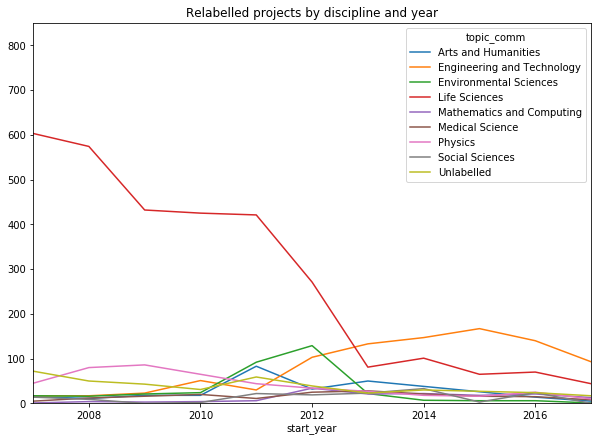

In [49]:
#Where are the unlabelled projects?
#Interestingly, a growing number of E&T projects started to be unlabelled in thr 2010s

proj_relabelled_time = pd.crosstab(labelled_df['topic_comm'],
                                  labelled_df['start_year'])
proj_relabelled_recent = proj_relabelled_time[[x for x in proj_relabelled_time.columns if x>2006]]

fig,ax = plt.subplots(1,figsize=(10,7))

proj_relabelled_recent.T.plot(ax=ax)

ax.set_ylim(0,850)
ax.set_title('Relabelled projects by discipline and year')

In [50]:
#Concatenate labelled and unlabelled projects into a single dataframe
all_projects = pd.concat([projects_labelled,labelled_df],axis=0).reset_index(drop=True)

#The missing values will be topic and subjects lists in unlabelled projects. We will them with ''
all_projects.fillna(value="",inplace=True)

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  app.launch_new_instance()


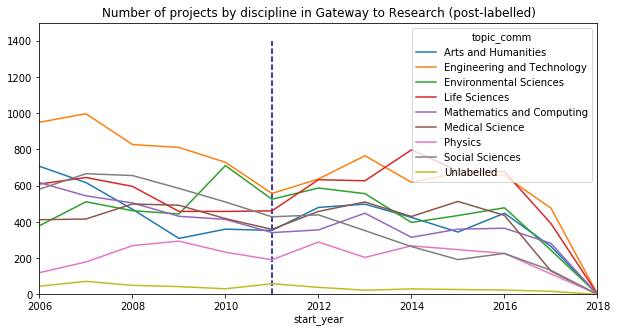

In [51]:
#Visualise all projects
all_projects_time = pd.crosstab(all_projects.start_year,all_projects['topic_comm'])
all_projects_time = all_projects_time.ix[[x>2005 for x in all_projects_time.index],:]

fig,ax = plt.subplots(1,figsize=(10,5))
all_projects_time.plot(ax=ax)

ax.set_xlim(2006,2018)
ax.set_ylim(0,1500)
ax.set_title('Discipline allocations by project (post-predictive analysis)')

ax.vlines(2011,ymin=0,ymax=1400,linestyles='dashed',colors='darkblue')
ax.set_title('Number of projects by discipline in Gateway to Research (post-labelled)')


plt.savefig('/Users/jmateosgarcia/Desktop/writes/manchester_presentation/post_labelled.pdf')



We have removed the 'bump' in life sciences project

In [52]:
#Create the projects_for_modelling df, which includes all projects we have been able to classify into disciplines.
projects_for_modelling = all_projects.ix[all_projects['topic_comm']!='Unlabelled',:].reset_index(drop=True)
projects_for_modelling.to_csv(int_data+'/{t}_projects_for_modelling.csv'.format(t=today))

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  from ipykernel import kernelapp as app


45592

## 6. Topic modelling

In [350]:
#What now?
#Run a topic model for each discipline

#Disc models is a container for the LDA models we are fitting with each discipline
disc_models_results=[]


for i in set(projects_for_modelling.topic_comm):
#for i in ['Mathematics and Computing']:
    print(i)
    my_corpus = projects_for_modelling.ix[projects_for_modelling.topic_comm==i,:]
    
    #Extract tokens
    tokens = pre_process_text(my_corpus)
    
    #Run the rest of the lda pipeline
    lda_mod = lda_model(tokens,tops=200)
    
    disc_models_results.append([i,lda_mod])

Physics
Arts and Humanities
Social Sciences
Medical Science
Engineering and Technology
Life Sciences
Environmental Sciences
Mathematics and Computing


In [356]:
#Save projects
with open(models_path+'/{t}_topic_models_detailed.p'.format(t=today),'wb') as outfile:
    pickle.dump(disc_models_results,outfile)

### Predict project topics

We want to estimate a project's topics, including topics in other disciplines. To do that, we generate topic distributions based on the models from other disciplines, weighted by the probability that the projects is in that discipline (based on our previous analysis of probabilities). Projects that are highly specialised in a discipline will receive low scores for topics outside, while more interdisciplinary projects will share topics from different disciplines

In [403]:
#We want to adjust the probabilities in the topic mix based on the relative importance of different
#disciplines in a project. We do this using the discipline prediction model we trained before.

#We will need to transform the keyword abstracts for all topics into a corpus, transform via PCA and use to predict 
#distribution probabilities again, but for the whole set.

#Final transformation. 

#We want to convert all tokens in abstracts into a corpus we will use to predict the probability that
#a document is in a category. We will use this to weight the probabilities of topics.

all_doc_tokens = pre_process_text(projects_for_modelling)

all_tokens = len(dictionary.token2id.values())

#Corpus for all documents (based on the dictionary we trained on the labelled dataset)
corpus_all = [dictionary.doc2bow(x) for x in all_doc_tokens]

#Produce the feature set
X_all = corpus2dense(corpus_all,num_terms=all_tokens)
X_all = X_all.T

#Principal component analysis using the model we trained on the labelled dataset
X_all_red = pca.transform(X_all)

#Extract labels for funders
X_fund = lb_bin_funder.fit_transform(projects_for_modelling.funder_name)[:,[0,1,2,3,4,6,7]]

#Concatenate
X_all_feats = np.concatenate((X_all_red,X_fund),axis=1)

#predicted topics
predicted_topic = rf_clf.predict_proba(X_all_feats)
predicted_topic_df = pd.DataFrame(predicted_topic,columns=lb.classes_).reset_index(drop=True)

#This df contains all the information we will use to predict the topics a project is in 
#(including projects outside its discipline)
projects_meta_topic = pd.concat([projects_for_modelling,predicted_topic_df],axis=1)

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished


In [409]:
projects_meta_topic.to_csv(int_data+'/{t}_projects_for_modelling_topic_probabilities.csv'.format(t=today))

In [405]:
#What is the crossover between disciplines?

#What is the crossover between disciplines?
100*projects_meta_topic.groupby('topic_comm')[predicted_topic_df.columns].mean()

,Arts and Humanities,Engineering and Technology,Environmental Sciences,Life Sciences,Mathematics and Computing,Medical Science,Physics,Social Sciences
topic_comm,,,,,,,,
Arts and Humanities,85.041118,3.092751,2.976004,1.883748,2.960609,1.777690,1.140941,6.328091
Engineering and Technology,1.390839,83.842948,2.337827,2.857476,6.542135,1.437527,1.260482,1.836293
Environmental Sciences,2.729051,3.583694,89.063595,3.655834,1.940780,1.834410,1.075957,1.657903
Life Sciences,4.201806,8.411790,6.896893,72.466332,4.787341,6.530875,1.777206,4.041214
Mathematics and Computing,1.955581,10.137205,2.003020,2.232238,80.815862,1.172713,0.882211,2.283074
Medical Science,1.340599,1.937968,1.353670,2.734534,0.980421,90.281805,0.649671,2.447273
Physics,1.511766,5.182761,2.293824,1.859955,2.191907,1.539617,84.587695,2.296282
Social Sciences,4.831174,2.075493,1.205251,1.242795,1.508892,1.877695,0.557298,83.987951


In [406]:
#This loop ru

model_container = []

#for d in disc_models_results:

for d in disc_models_results:
    
    #Extract each model.
    disc = d[0]
    print(disc)
    
    text_in_discipline = projects_meta_topic.ix[
        projects_meta_topic['topic_comm']==disc,:].reset_index(drop=True)
    
    #Extract tokens
    tokens = pre_process_text(text_in_discipline)
    
    #Extract model
    lda_mod =  d[1]
    
    #Extract labels
    word_distributions = lda_mod.show_topics(num_topics=200)
    
    #This is splitting by the '"' and then getting the first 8 keywords, to read the topics.
    labs = ["_".join(list(np.array(x[1].split('"'))[[1,3,5,7,9,11,13,15]])) for x in word_distributions]
    
    #Predict
    #We need to creaate the bow again
    dictionary_disc = corpora.Dictionary(tokens)

    #Create bow corpus (for all documents)
    bow_all = [dictionary_disc.doc2bow(x) for x in all_doc_tokens]
    
    #Document-term matrix
    doc_term_matrix = np.array(lda_mod[bow_all])
    
    #Need to convert the transformed corpus into a df
    lda_preds = pd.DataFrame([{x[0]:x[1] for x in el} for el in doc_term_matrix])
    
    #This is a hack. In one of the disciplines (social sciences) the number of columns is lower than the 
        #number of columns, which was throwing an error when trying to label the columns. 
        #This removes the 'offending' column. I need to check
        #what this does to the indices, and determine why it happens!
    labs_2=[l for n,l in enumerate(labs) if n in list(lda_preds.columns)]
    
    print(len(labs_2))
    
    #Name columns
    lda_preds.columns = labs_2
    lda_preds.fillna(value=0,inplace=True)
    
    #Add df with project ids
    #lda_preds_labelled = pd.concat([my_corpus.href,lda_preds],axis=1)
    
    model_container.append([disc,lda_preds])


Physics
193
Arts and Humanities
199
Social Sciences
200
Medical Science
200
Engineering and Technology
200
Life Sciences
200
Environmental Sciences
200
Mathematics and Computing
200


In [410]:
with open(models_path+'/{t}_model_predictions.p'.format(t=today),'wb') as outfile:
    pickle.dump(model_container,outfile)

In [415]:
#Remove generic topics from each discipline.
#Produce a list for each, output, label in a spreadsheet, reload and remove.

discs = [x[0] for x in disc_models_results]

#Extract most frequently mentioned topics per topic_comm / discipline
topic_counts = pd.concat([
    obtain_topic_ranking(d,df[1]).reset_index(drop=True) for d,df in zip(discs,model_container)],axis=0)

#Extract
topic_counts.to_csv(int_data+'/{t}_top_topics_per_discipline.csv'.format(t=today),index=False)

#We will label these in excel and reload for filtering

In [444]:
#Weight topics based on probabilities. Here we weight the probabilities for a topic based on the
#probability that it is in a discipline

#Create a model to discipline lookup
model_container_lookup = {x[0]:x[1] for x in model_container}

#Create a df with the topics for all disciplines (after weighting them)
#This list comprehension multiplies the project topic mix in each discipline by the weight

#First we need to re-normalise the probabilities (in some cases they added to more than 1)
predicted_topic_norm = predicted_topic_df.apply(lambda x: x/predicted_topic_df.sum(axis=1))

#Weighted topics
weighted_topics = [[disc,model_container_lookup[disc].apply(lambda x: x*predicted_topic_norm.ix[:,disc])] for disc in set(
    predicted_topic_norm.columns)]

project_topics_df = pd.concat([x[1] for x in weighted_topics],axis=1).reset_index(drop=True)

#Also create a topic-discipline lookup
topic_discipline_df = pd.concat([pd.DataFrame({'disc':x[0],'tops':x[1].columns}) for x in model_container])
topic_discipline_lookup = {x:y for x,y in zip(topic_discipline_df['tops'],topic_discipline_df['disc'])}

### Generate outputs

In [445]:
#Here we combine all the data to produce outputs for analysis
#Select relevant variables for the project metadata df
relevant_vars  = ['abstract_texts','topic_comm',
                 'funder_id','funder_name','grant_cats','links','project_id',
                 'research_subjects','research_topics','start','start_year','status','value_pounds']

#This contains all metadata about projects
project_metadata_df = projects_for_modelling[relevant_vars]

#Fix the links json (we loaded it as a string)
project_metadata_df['links'] = [json.loads(x) for x in project_metadata_df['links']]

#We combine with the organiisation df 
#Rename columns
#NB: We are excluding from the analysis non-UK based organisations!


org_geo['nation']= ['England' if x[0]== 'E' else 'Wales' if x[0]=='W' else 
                          'Scotland' if x[0] == 'S' else 'Northern Ireland' if x[0]=='N' else np.nan
                          for x in org_geo.LAD13CD]

#Create a list of Welsh local authorities
welsh_lads = list(set([x for x,y in zip(org_geo['LAD13NM'],org_geo['is_wales']) if y==True]))


#This contains the topics - we add a tm prefix to the topic names to make subsetting easier later.
project_topics_df.columns = ['tm_'+x for x in project_topics_df.columns]

#Create a lookup between projects and organisations taking into account their roles
project_org_lu = pd.DataFrame([[href,vals['rel'],vals['href']] 
                                for href,links in zip(project_metadata_df.project_id,
                                                      project_metadata_df.links) 
                                for vals in links['link'] if 'ORG' in vals['rel'].split("_")],
                              columns=['project_id','role','org_id'])
        
#Shorten the organisation id
project_org_lu['org_id_short'] = [x.split("/")[-1] for x in project_org_lu['org_id']]

#Merge everything (the pro)
output_df = pd.merge(pd.merge(pd.concat([project_metadata_df,project_topics_df],axis=1),
                     project_org_lu,left_on='project_id',right_on='project_id',how='outer'),
                     org_geo,left_on='org_id_short',right_on='id',how='left')

In [446]:
#Save outputs
processed_outputs = [output_df,topic_discipline_lookup,welsh_lads]
with open(int_data+'/{t}_gtr_processed_outputs.p'.format(t=today),'wb') as outfile:
    pickle.dump(processed_outputs,outfile)

In [447]:
#Final checks and processing
#Project data is the project metadata + topics + geodata
projects = output_df

#NB drop projects with no LAD data.
projects.dropna(axis=0,subset=['LAD13NM'],inplace=True)
projects.reset_index(drop=False,inplace=True)

#Discipline lookup looks up topics vs disciplines
discipline_lookup = topic_discipline_lookup

In [73]:
#We want to remove  very generic topics
topic_columns = pd.Series([x for x in projects.columns if x.split("_")[0]=='tm'])

projects_topics = projects[topic_columns]

projects_topics_aggregated = projects_topics.sum()

projects_topics_aggregated.sort_values(
    ascending=False).to_csv(int_data+'/{t}_topics_for_tidying.csv'.format(t=today))

In [72]:
#NB this labelling was carried out on the 17th May 2017
topics_filtered = pd.read_csv(int_data+'/2017_5_13_topics_for_tidying_labelled.csv')

#We remove topics which don't refer to an area of research, but to the language 
#that researchers use to describe their work in proposals. We have also remove topics related to
#formats (e.g. a workshop, a book)

topics_filtered.ix[topics_filtered['drop']==1,:]

,topic,agg_prob,drop
0,tm_abstract_proposal_sensitive_detail_included...,1440.432875,1.0
1,tm_research_uk_network_academic_activity_indus...,920.768481,1.0
2,tm_one_make_way_use_work_many_u_much,601.358810,1.0
5,tm_abstract_sensitive_funded_required_informat...,523.378778,1.0
7,tm_mechanism_cause_role_function_development_t...,428.256540,1.0
8,tm_project_research_work_public_team_academic_...,414.326908,1.0
13,tm_network_research_academic_workshop_internat...,354.685602,1.0
17,tm_university_research_group_collaboration_pro...,317.614910,1.0
18,tm_research_area_researcher_collaboration_uk_n...,317.123463,1.0
23,tm_need_research_problem_knowledge_help_work_u...,288.888448,1.0


In [74]:
#Remove the topics topics
topics_retained = [x for x,f in zip(topics_filtered.topic,topics_filtered['drop']) if f !=1]
projects_clean = projects[[x for x in projects.columns 
                           if x in [x for x in projects.columns if x.split("_")[0]!='tm']+topics_retained]]

In [79]:
#The checks suggest that we the topics in general reflect the real subjects of a project
random_check = spot_check_topics(projects_clean,10)

random_check

#NB there are ~2000 projects with missing abstracts. 
#We keep them because we still have their research subjects and topics to model them

In [475]:
#We clean the project df, removing repeated projects (here we had organisations in order to simplify the
#geo-analysis later)

#Drop duplicates based on ids
unique_projects_clean = projects_clean.drop_duplicates('project_id')

#Create a topics df with the topics we retained based on the analysis above
unique_projects_topics = unique_projects_clean[topics_retained]

#Flip because we want to extract the principal component projects (in other words, linear combinations of projects that
#explain most of the variance in the topic distributions)
#This already will be capturing some of the relations between topics.

#Transpose in order to turn projects into features, and binarise based on probabilities (so that
#we can analyse the data using Jaccard distances which consider overlaps between sets)
unique_projects_trans = np.array(unique_projects_topics.applymap(lambda x: 0 if x<0.01 else 1).T)
#unique_projects_trans = np.array(unique_projects_topics.T)

#The affinity matrix is a df where the cells represent the similarity between variables based on the jaccard metrix
aff_mat = pd.DataFrame(squareform(1-pdist(unique_projects_trans,metric='jaccard')),index=topics_retained,columns=topics_retained)

#Convert missing values to 0
aff_mat.fillna(value=0,inplace=True)

In [477]:
#Discipline lookup list to subset the correlation matrix by the right topics 
#so we can perform the clustering analysis *inside* disciplines.
discipline_lookup_list = pd.DataFrame(discipline_lookup,['discipline']).T.reset_index(drop=False).groupby('discipline')['index'].apply(lambda x: list(x))

In [489]:
#We want to cluster topics
#Result container
result_container = []

#We loop over the disciplines and perform the clustering
for i in discipline_lookup_list.index:
    
    #Print the discipline
    print(i)

    #Create a list of selected topics (nb we need to add 'tm', the prefix for the topics in the df)
    selected = ['tm_'+x for x in discipline_lookup_list[i] if 'tm_'+x in topics_retained]
    
    #Subset the affinity matrix
    aff_mat_disc = aff_mat.ix[selected,selected]

    #Initialise the clustering object (we are using a precomputed affinity matrix)
    af = AffinityPropagation(damping=0.9,affinity='precomputed')
    
    #Fit and predict with the affinity matrix
    af.fit_predict(np.array(aff_mat_disc))
    
    #Use the previous function to produce the results lookup
    results = clusters_df(selected,af.labels_,i)
    
    #Do the same thing with community detection
    net = nx.from_numpy_matrix(np.array(aff_mat_disc))
    net_lab = nx.relabel_nodes(net,{x:y for x,y in enumerate(aff_mat_disc.index)})
    comms = community.best_partition(net_lab,resolution=0.75)
    
    comms_df = pd.DataFrame(comms,index=['comm']).T.sort_values('comm')
    comms_df['disc']=i
  
    #Output findings
    result_container.append(comms_df)

Arts and Humanities
Engineering and Technology
Environmental Sciences
Life Sciences
Mathematics and Computing
Medical Science
Physics
Social Sciences


In [491]:
#Concatenate them all into a single lookup for checking and labelling
all_cluster_allocations = pd.concat(result_container,axis=0)
all_cluster_allocations.to_csv(int_data+'/{t}_clusters_to_label_comm_2.csv'.format(t=today))

#After some manual labelling we load a lookup with labelled clusters
topic_cluster_lookup = pd.read_csv(int_data+'/2017_5_17_clusters_labelled.csv')

In [494]:
#Create a topic-discipline lookup for the network analysis below
topic_comm_disc_lookup = {y:x for x,y in zip(topic_cluster_lookup.disc,topic_cluster_lookup.topic_community)}

#Now we convert between topics and topic clusters.

#Melt (NB we reset the index to use it as an id var and identifier later)
project_topics_clean = pd.melt(projects_topics[topics_retained].reset_index(drop=False),id_vars='index')
project_topics_clean.rename(columns={'variable':'topic','value':'prob'},inplace=True)

#Merge variables
projects_topics_merged = pd.merge(project_topics_clean,topic_cluster_lookup[['topic','topic_community']],
                                 left_on='topic',right_on='topic')

#Pivot to produce the topic aggregations
projects_topic_comms = pd.pivot_table(projects_topics_merged,
                                index='index',columns='topic_community',values='prob',aggfunc='sum')

In [495]:
#Produce dataframe with metadata and topic communities, and process with classes

#Get project metadata
proj_org_meta = projects_clean[[x for x in projects_clean.columns if x.split("_")[0]!='tm']]

#Label community topics to make things easier to separate later
projects_topic_comms.columns = ['tc_'+x for x in projects_topic_comms.columns]

#Concatenate. This will be the input for the rest of our analysis
projects_topic_comms = pd.concat([proj_org_meta,projects_topic_comms],axis=1)

projects_topic_comms.drop('tc_drop',axis=1,inplace=True)


In [498]:
random_check_2 = spot_check_topics(projects_topic_comms,10,topic_prefix='tc')

for i in np.arange(len(random_check_2)):

    print(random_check_2.ix[i,0])
    
    print("\n")
    
    print(random_check_2.ix[i,'abstract_texts'][0:500])

    print("\n")

tc_energy_transport_technology_tc_systems_infrastructure_tc_chemistry_biochemistry_tc_photonics_imaging_quantum_tc_electronics_transistors


Research in the field of condensed phase reactive flow encompasses a broad range of interests ranging from safety considerations in the chemical processing industries, to commercial mining activities and defence related research. This proposal is concerned with the establishment of a network amongst these disparate technical communities in the UK. The aims are to provide a means of developing joint research applications, providing bibliographic data support, benchmarking UK research on modelling


tc_environmental_policy_tc_minerals_fuels_tc_modelling_&_sensors_tc_ecosystems_tc_applications_devices_users


The UK has a substantial nuclear legacy (large quantities of nuclear contaminated land, waste, and aging nuclear facilities). In the coming decades, these wastes will be managed via geodisposal and legacy nuclear sites will be decommissioned at 

In [501]:
projects_topic_comms.to_csv(int_data+'/{t}_projects_topics.csv'.format(t=today))

In [503]:
with open(int_data+'/topic_comm_disc_lookup.p','wb') as out:
    pickle.dump(topic_comm_disc_lookup,out)

# To remove later - some processing for BEIS talk

In [93]:
# BEIS presentation
with open(int_data+'/gtr_processed_outputs.p','rb') as infile:
    processed_outputs_beis = pickle.load(infile)


In [107]:
#Idea - create a matrix of connections between topics (e.g. correlation) and visualise as a network

topics = processed_outputs_beis[0].ix[:,[x.split("_")[0]=='tm' for x in processed_outputs_beis[0].columns]]

In [113]:
topics_aff_mat = pd.DataFrame(squareform(1-pdist(topics.T,metric='cosine')),index=topics.columns,
                       columns=topics.columns)

In [171]:
topic_aff_mat_long = pd.melt(topics_aff_mat.reset_index(drop=False),id_vars='index')
topic_aff_mat_long.columns = ['source','target','weight']


topic_net = nx.from_pandas_dataframe(topic_aff_mat_long,source='source',target='target',edge_attr='weight')

In [191]:
#Focus on nodes on the 25% pc

thres = pd.Series([x['weight'] for a,b,x in topic_net.edges(data=True)]).quantile(q=0.95)


topic_net_selected = nx.Graph([(a,b,x) for a,b,x in topic_net.edges(data=True) if x['weight']>thres])

for node in topic_net_selected.node:
    
    name = "_".join(node.split("_")[1:])
    
    try:
        topic_net_selected.node[node]['discipline'] = processed_outputs_beis[1][name]
    except:
        topic_net_selected.node[node]['discipline'] = 'none'


In [192]:
nx.write_graphml(topic_net_selected,int_data+'/topic_net_test.graphml')

In [199]:
labs = [x for x,y in zip(processed_outputs_beis[1].keys(),processed_outputs_beis[1].values()) 
        if y =='Mathematics and Computing']

In [205]:
for i in sorted(labs):
    print("\n")
    print(i)
#    print("\n")



active_mode_aircraft_system_developed_flight_path_control


agent_intended_empirical_based_application_provided_environment_model


algebra_c_operator_b_hilbert_classification_system_w


algorithm_problem_solution_optimisation_research_optimization_many_optimal


animal_cognitive_project_action_learning_compound_model_novel


application_web_software_development_way_service_heart_distributed


archive_contemporary_medium_humanity_lay_creative_catalogue_analyst


array_optimal_field_sound_microphone_auditory_direct_investigated


artefact_rfid_tag_voice_equipment_identification_surveillance_people


august_published_instability_common_journal_represents_listed_flame


bone_pain_replacement_secondary_book_strain_spinal_pathogen


brain_activity_region_information_neural_different_human_eeg


brownian_planar_heating_unify_characterization_invariance_growth_intensely


category_local_stable_localisation_body_homotopy_compact_impressed


cell_biological_biology_modelling_plant_mathematica

In [58]:
#Topic network

#######
#SNA functions
#######

def extract_network_from_corpus(label_corpus,edge_attr="None",stop_words=None):
    """
    Extracts a network object from a list or series where every observation is a list of co-ocurring observations
    (e.g. interacting agents, or co-occurring words). 
    In the network output, the labels are nodes and co-occurrences between them are edges. 
    Weight is number of co-occurrences. There is the option to consider additional edge attributes.

    Inputs:
    label_corpus: corpus of documents with label co-occurrence or node interaction.
    edge_attr: an edge attribute associated to the interaction. It defaults to the string none (which we use
        for control flow)
    stop_words: labels to remove (e.g. generic terms)
    
    Returns a networkx object.
    
    """
    label_pairs_container =[]
    
    #!!! TODO Using type to control flow feels a bit hacky.
    if type(edge_attr) != str:
        #Container for pairs of labels
        edge_attr_name = edge_attr.name
    
    #For each pair
    for i in range(len(label_corpus)):
    
    #List of tuples where every tuple is a combination of topics
        pairs = list(combinations(label_corpus[i],2))
    
    #Extract these as lists of dicts capturing connections between topics, and add those to the container.
    #NB we are sorting the tuples to make sure that we don't duplicate edges.
        if len(pairs)>0:
            cont = [{'e1':sorted(tup)[0],'e2':sorted(tup)[1]} for tup in pairs]
            
            #Give each edge its corresponding attribute (if we have one)
            if type(edge_attr) != str:
                for d in cont:
                    d.update({edge_attr_name: edge_attr[i]})

            label_pairs_container.append(cont)

    #Flatten dict list and turn into DF
    label_pairs_df = pd.DataFrame([ds for sublist in label_pairs_container for ds in sublist])
    
    #Extract weights (depends on edge_attr)
    if type(edge_attr) != str:
        label_edgelist = pd.DataFrame(label_pairs_df.groupby(['e1','e2',edge_attr_name]
                                                        ).size()).reset_index().sort_values(by=0,ascending=False)
    else:
        label_edgelist = pd.DataFrame(label_pairs_df.groupby(['e1','e2']
                                                        ).size()).reset_index().sort_values(by=0,ascending=False)
    
    label_edgelist.rename(columns={0:'weight'},inplace=True)
    
    #Remove stop-words
    if stop_words != None:
        has_ttm =  [x in stop_words or y in stop_words for x,y in zip(label_edgelist['e1'],label_edgelist['e2'])]
        label_edgelist = label_edgelist[-pd.Series(has_ttm)]
    
    #Create label graph
    if type(edge_attr) != str:
        label_graph = nx.from_pandas_dataframe(label_edgelist,'e1','e2',['weight',edge_attr_name])
    else:
        label_graph = nx.from_pandas_dataframe(label_edgelist,'e1','e2',['weight'])
    
    return(label_graph)    


# -*- coding: utf-8 -*-
"""
Algorithms for calculating min/max spanning trees/forests.

"""
#    Copyright (C) 2015 NetworkX Developers
#    Aric Hagberg <hagberg@lanl.gov>
#    Dan Schult <dschult@colgate.edu>
#    Pieter Swart <swart@lanl.gov>
#    Loïc Séguin-C. <loicseguin@gmail.com>
#    All rights reserved.
#    BSD license.

__all__ = [
    'minimum_spanning_edges', 'maximum_spanning_edges',
    'minimum_spanning_tree', 'maximum_spanning_tree',
]

from heapq import heappop, heappush
from itertools import count

import networkx as nx
from networkx.utils import UnionFind, not_implemented_for


@not_implemented_for('multigraph')
def boruvka_mst_edges(G, minimum=True, weight='weight', keys=False, data=True):
    """Iterates over the edges of a minimum spanning tree as computed by
    Borůvka's algorithm.

    `G` is a NetworkX graph. Also, the edges must have distinct weights,
    otherwise the edges may not form a tree.

    `weight` is the edge attribute that stores the edge weights. Each
    edge in the graph must have such an attribute, otherwise a
    :exc:`KeyError` will be raised.

    If `data` is True, this iterator yields edges of the form
    ``(u, v, d)``, where ``u`` and ``v`` are nodes and ``d`` is the edge
    attribute dictionary. Otherwise, it yields edges of the form
    ``(u, v)``.

    The `keys` argument is ignored, since this function is not
    implemented for multigraphs; it exists only for consistency with the
    other minimum spanning tree functions.

    """
    opt = min if minimum else max
    # Initialize a forest, assuming initially that it is the discrete
    # partition of the nodes of the graph.
    forest = UnionFind(G)

    def best_edge(component):
        """Returns the optimum (minimum or maximum) edge on the edge
        boundary of the given set of nodes.

        A return value of ``None`` indicates an empty boundary.

        """
        # TODO In Python 3.4 and later, we can just do
        #
        #     boundary = nx.edge_boundary(G, component, data=weight)
        #     return opt(boundary, key=lambda e: e[-1][weight], default=None)
        #
        # which is better because it doesn't require creating a list.
        boundary = list(nx.edge_boundary(G, component, data=True))
        if not boundary:
            return None
        return opt(boundary, key=lambda e: e[-1][weight])

    # Determine the optimum edge in the edge boundary of each component
    # in the forest.
    best_edges = (best_edge(component) for component in forest.to_sets())
    best_edges = [edge for edge in best_edges if edge is not None]
    # If each entry was ``None``, that means the graph was disconnected,
    # so we are done generating the forest.
    while best_edges:
        # Determine the optimum edge in the edge boundary of each
        # component in the forest.
        #
        # This must be a sequence, not an iterator. In this list, the
        # same edge may appear twice, in different orientations (but
        # that's okay, since a union operation will be called on the
        # endpoints the first time it is seen, but not the second time).
        #
        # Any ``None`` indicates that the edge boundary for that
        # component was empty, so that part of the forest has been
        # completed.
        #
        # TODO This can be parallelized, both in the outer loop over
        # each component in the forest and in the computation of the
        # minimum. (Same goes for the identical lines outside the loop.)
        best_edges = (best_edge(component) for component in forest.to_sets())
        best_edges = [edge for edge in best_edges if edge is not None]
        # Join trees in the forest using the best edges, and yield that
        # edge, since it is part of the spanning tree.
        #
        # TODO This loop can be parallelized, to an extent (the union
        # operation must be atomic).
        for u, v, d in best_edges:
            if forest[u] != forest[v]:
                if data:
                    yield u, v, d
                else:
                    yield u, v
                forest.union(u, v)


def kruskal_mst_edges(G, minimum, weight='weight', keys=True, data=True):
    subtrees = UnionFind()
    if G.is_multigraph():
        edges = G.edges(keys=True, data=True)
    else:
        edges = G.edges(data=True)
    getweight = lambda t: t[-1].get(weight, 1)
    edges = sorted(edges, key=getweight, reverse=not minimum)
    is_multigraph = G.is_multigraph()
    # Multigraphs need to handle edge keys in addition to edge data.
    if is_multigraph:
        for u, v, k, d in edges:
            if subtrees[u] != subtrees[v]:
                if keys:
                    if data:
                        yield (u, v, k, d)
                    else:
                        yield (u, v, k)
                else:
                    if data:
                        yield (u, v, d)
                    else:
                        yield (u, v)
                subtrees.union(u, v)
    else:
        for u, v, d in edges:
            if subtrees[u] != subtrees[v]:
                if data:
                    yield (u, v, d)
                else:
                    yield (u, v)
                subtrees.union(u, v)


def prim_mst_edges(G, minimum, weight='weight', keys=True, data=True):
    is_multigraph = G.is_multigraph()
    push = heappush
    pop = heappop

    nodes = list(G)
    c = count()

    sign = 1
    if not minimum:
        sign = -1

    while nodes:
        u = nodes.pop(0)
        frontier = []
        visited = [u]
        if is_multigraph:
            for u, v, k, d in G.edges(u, keys=True, data=True):
                push(frontier, (d.get(weight, 1) * sign, next(c), u, v, k))
        else:
            for u, v, d in G.edges(u, data=True):
                push(frontier, (d.get(weight, 1) * sign, next(c), u, v))
        while frontier:
            if is_multigraph:
                W, _, u, v, k = pop(frontier)
            else:
                W, _, u, v = pop(frontier)
            if v in visited:
                continue
            visited.append(v)
            nodes.remove(v)
            if is_multigraph:
                for _, w, k2, d2 in G.edges(v, keys=True, data=True):
                    if w in visited:
                        continue
                    new_weight = d2.get(weight, 1) * sign
                    push(frontier, (new_weight, next(c), v, w, k2))
            else:
                for _, w, d2 in G.edges(v, data=True):
                    if w in visited:
                        continue
                    new_weight = d2.get(weight, 1) * sign
                    push(frontier, (new_weight, next(c), v, w))
            # Multigraphs need to handle edge keys in addition to edge data.
            if is_multigraph and keys:
                if data:
                    yield u, v, k, G[u][v]
                else:
                    yield u, v, k
            else:
                if data:
                    yield u, v, G[u][v]
                else:
                    yield u, v

ALGORITHMS = {
    'boruvka': boruvka_mst_edges,
    u'borůvka': boruvka_mst_edges,
    'kruskal': kruskal_mst_edges,
    'prim': prim_mst_edges
}


@not_implemented_for('directed')
def _spanning_edges(G, minimum, algorithm='kruskal', weight='weight',
                    keys=True, data=True):
    try:
        algo = ALGORITHMS[algorithm]
    except KeyError:
        msg = '{} is not a valid choice for an algorithm.'.format(algorithm)
        raise ValueError(msg)

    return algo(G, minimum=minimum, weight=weight, keys=keys, data=data)


def minimum_spanning_edges(G, algorithm='kruskal', weight='weight', keys=True,
                           data=True):
    """Generate edges in a minimum spanning forest of an undirected
    weighted graph.

    A minimum spanning tree is a subgraph of the graph (a tree)
    with the minimum sum of edge weights.  A spanning forest is a
    union of the spanning trees for each connected component of the graph.

    Parameters
    ----------
    G : undirected Graph
       An undirected graph. If `G` is connected, then the algorithm finds a
       spanning tree. Otherwise, a spanning forest is found.

    algorithm : string
       The algorithm to use when finding a minimum spanning tree. Valid
       choices are 'kruskal', 'prim', or 'boruvka'. The default is
       'kruskal'.

    weight : string
       Edge data key to use for weight (default 'weight').

    keys : bool
       Whether to yield edge key in multigraphs in addition to the
       edge. If `G` is not a multigraph, this is ignored.

    data : bool, optional
       If True yield the edge data along with the edge.

    Returns
    -------
    edges : iterator
       An iterator over tuples representing edges in a minimum spanning
       tree of `G`.

       If `G` is a multigraph and both `keys` and `data` are
       True, then the tuples are four-tuples of the form `(u, v, k,
       w)`, where `(u, v)` is an edge, `k` is the edge key
       identifying the particular edge joining `u` with `v`, and
       `w` is the weight of the edge. If `keys` is True but
       `data` is False, the tuples are three-tuples of the form
       `(u, v, k)`.

       If `G` is not a multigraph, the tuples are of the form `(u, v,
       w)` if `data` is True or `(u, v)` if `data` is
       False.

    Examples
    --------
    >>> from networkx.algorithms import tree

    Find minimum spanning edges by Kruskal's algorithm

    >>> G = nx.cycle_graph(4)
    >>> G.add_edge(0, 3, weight=2)
    >>> mst = tree.minimum_spanning_edges(G, algorithm='kruskal', data=False)
    >>> edgelist = list(mst)
    >>> sorted(edgelist)
    [(0, 1), (1, 2), (2, 3)]

    Find minimum spanning edges by Prim's algorithm

    >>> G = nx.cycle_graph(4)
    >>> G.add_edge(0, 3, weight=2)
    >>> mst = tree.minimum_spanning_edges(G, algorithm='prim', data=False)
    >>> edgelist = list(mst)
    >>> sorted(edgelist)
    [(0, 1), (1, 2), (2, 3)]

    Notes
    -----
    For Borůvka's algorithm, each edge must have a weight attribute, and
    each edge weight must be distinct.

    For the other algorithms, if the graph edges do not have a weight
    attribute a default weight of 1 will be used.

    Modified code from David Eppstein, April 2006
    http://www.ics.uci.edu/~eppstein/PADS/

    """
    return _spanning_edges(G, minimum=True, algorithm=algorithm,
                           weight=weight, keys=keys, data=data)



def maximum_spanning_edges(G, algorithm='kruskal', weight='weight', data=True):
    """Generate edges in a maximum spanning forest of an undirected
    weighted graph.

    A maximum spanning tree is a subgraph of the graph (a tree)
    with the maximum possible sum of edge weights.  A spanning forest is a
    union of the spanning trees for each connected component of the graph.

    Parameters
    ----------
    G : undirected Graph
       An undirected graph. If `G` is connected, then the algorithm finds a
       spanning tree. Otherwise, a spanning forest is found.

    algorithm : string
       The algorithm to use when finding a maximum spanning tree. Valid
       choices are 'kruskal', 'prim', or 'boruvka'. The default is
       'kruskal'.

    weight : string
       Edge data key to use for weight (default 'weight').

    keys : bool
       Whether to yield edge key in multigraphs in addition to the
       edge. If `G` is not a multigraph, this is ignored.

    data : bool, optional
       If True yield the edge data along with the edge.

    Returns
    -------
    edges : iterator
       An iterator over tuples representing edges in a maximum spanning
       tree of `G`.

       If `G` is a multigraph and both `keys` and `data` are
       True, then the tuples are four-tuples of the form `(u, v, k,
       w)`, where `(u, v)` is an edge, `k` is the edge key
       identifying the particular edge joining `u` with `v`, and
       `w` is the weight of the edge. If `keys` is True but
       `data` is False, the tuples are three-tuples of the form
       `(u, v, k)`.

       If `G` is not a multigraph, the tuples are of the form `(u, v,
       w)` if `data` is True or `(u, v)` if `data` is
       False.

    Examples
    --------
    >>> from networkx.algorithms import tree

    Find maximum spanning edges by Kruskal's algorithm

    >>> G = nx.cycle_graph(4)
    >>> G.add_edge(0, 3, weight=2)
    >>> mst = tree.maximum_spanning_edges(G, algorithm='kruskal', data=False)
    >>> edgelist = list(mst)
    >>> sorted(edgelist)
    [(0, 1), (0, 3), (1, 2)]

    Find maximum spanning edges by Prim's algorithm

    >>> G = nx.cycle_graph(4)
    >>> G.add_edge(0,3,weight=2) # assign weight 2 to edge 0-3
    >>> mst = tree.maximum_spanning_edges(G, algorithm='prim', data=False)
    >>> edgelist = list(mst)
    >>> sorted(edgelist)
    [(0, 1), (0, 3), (3, 2)]

    Notes
    -----
    For Borůvka's algorithm, each edge must have a weight attribute, and
    each edge weight must be distinct.

    For the other algorithms, if the graph edges do not have a weight
    attribute a default weight of 1 will be used.

    Modified code from David Eppstein, April 2006
    http://www.ics.uci.edu/~eppstein/PADS/
    """
    return _spanning_edges(G, minimum=False, algorithm=algorithm,
                           weight=weight, data=data)



@not_implemented_for('directed')
def _optimum_spanning_tree(G, algorithm, minimum, weight='weight'):
    # When creating the spanning tree, we can ignore the key used to
    # identify multigraph edges, since a tree is guaranteed to have no
    # multiedges. This is why we use `keys=False`.
    edges = _spanning_edges(G, minimum, algorithm=algorithm, weight=weight,
                            keys=False, data=True)
    T = nx.Graph(edges)

    # Add isolated nodes
    if len(T) != len(G):
        T.add_nodes_from(nx.isolates(G))

    # Add node and graph attributes as shallow copy
    for n in T:
        T.node[n].update(G.node[n])
    T.graph = G.graph.copy()

    return T


def minimum_spanning_tree(G, weight='weight', algorithm='kruskal'):
    """Returns a minimum spanning tree or forest on an undirected graph `G`.

    Parameters
    ----------
    G : undirected graph
        An undirected graph. If `G` is connected, then the algorithm finds a
        spanning tree. Otherwise, a spanning forest is found.

    weight : str
       Data key to use for edge weights.

    algorithm : string
       The algorithm to use when finding a minimum spanning tree. Valid
       choices are 'kruskal', 'prim', or 'boruvka'. The default is
       'kruskal'.

    Returns
    -------
    G : NetworkX Graph
       A minimum spanning tree or forest.

    Examples
    --------
    >>> G = nx.cycle_graph(4)
    >>> G.add_edge(0, 3, weight=2)
    >>> T = nx.minimum_spanning_tree(G)
    >>> sorted(T.edges(data=True))
    [(0, 1, {}), (1, 2, {}), (2, 3, {})]


    Notes
    -----
    For Borůvka's algorithm, each edge must have a weight attribute, and
    each edge weight must be distinct.

    For the other algorithms, if the graph edges do not have a weight
    attribute a default weight of 1 will be used.

    There may be more than one tree with the same minimum or maximum weight.
    See :mod:`networkx.tree.recognition` for more detailed definitions.

    """
    return _optimum_spanning_tree(G, algorithm=algorithm, minimum=True,
                                  weight=weight)



def maximum_spanning_tree(G, weight='weight', algorithm='kruskal'):
    """Returns a maximum spanning tree or forest on an undirected graph `G`.

    Parameters
    ----------
    G : undirected graph
        An undirected graph. If `G` is connected, then the algorithm finds a
        spanning tree. Otherwise, a spanning forest is found.

    weight : str
       Data key to use for edge weights.

    algorithm : string
       The algorithm to use when finding a minimum spanning tree. Valid
       choices are 'kruskal', 'prim', or 'boruvka'. The default is
       'kruskal'.


    Returns
    -------
    G : NetworkX Graph
       A minimum spanning tree or forest.


    Examples
    --------
    >>> G = nx.cycle_graph(4)
    >>> G.add_edge(0, 3, weight=2)
    >>> T = nx.maximum_spanning_tree(G)
    >>> sorted(T.edges(data=True))
    [(0, 1, {}), (0, 3, {'weight': 2}), (1, 2, {})]


    Notes
    -----
    For Borůvka's algorithm, each edge must have a weight attribute, and
    each edge weight must be distinct.

    For the other algorithms, if the graph edges do not have a weight
    attribute a default weight of 1 will be used.

    There may be more than one tree with the same minimum or maximum weight.
    See :mod:`networkx.tree.recognition` for more detailed definitions.

    """
    return _optimum_spanning_tree(G, algorithm=algorithm, minimum=False,
                                  weight=weight)


## Additional charts and analyses for the D4PC paper

In [71]:
gtr_topic_network_max = maximum_spanning_tree(gtr_topic_network)


for node in gtr_topic_network_max.node:
    gtr_topic_network_max.node[node]['comm'] = str(topic_allocation[node])

In [72]:
nx.write_graphml(gtr_topic_network_max,proc_data+'/gtr_topic_network_max.graphml')

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:19: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


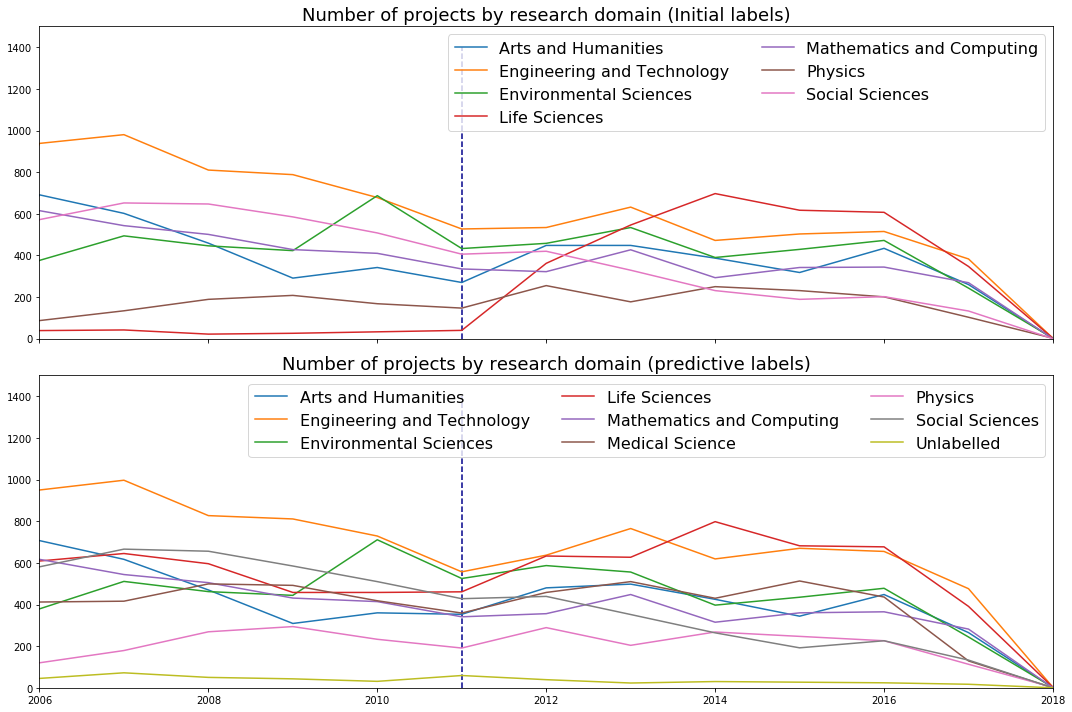

In [141]:
#Time series analysis suggests something quite strange with Life Sciences
times = pd.crosstab(project_subj.topic_comm,project_subj.start_year).T

fig,ax = plt.subplots(nrows=2,figsize=(15,10),sharex=True)

times.plot(ax=ax[0])

ax[0].set_ylim(0,1500)
ax[0].set_xlim(2006,2018)
ax[0].vlines(2011,ymin=0,ymax=1400,linestyles='dashed',colors='darkblue')
ax[0].set_title('Number of projects by research domain (Initial labels)',fontsize=18)
ax[0].legend(ncol=2,loc=1,fontsize=16)
ax[0].set_xlabel('Year')

#plt.savefig('/Users/jmateosgarcia/Desktop/writes/manchester_presentation/pre_labelled.pdf')

#Visualise all projects
all_projects_time = pd.crosstab(all_projects.start_year,all_projects['topic_comm'])
all_projects_time = all_projects_time.ix[[x>2005 for x in all_projects_time.index],:]


all_projects_time.plot(ax=ax[1])

ax[1].set_xlim(2006,2018)
ax[1].set_ylim(0,1500)
ax[1].set_title('Number of projects by research domain (predictive labels)',fontsize=18)

ax[1].vlines(2011,ymin=0,ymax=1400,linestyles='dashed',colors='darkblue')
#ax[1].set_title('Predicted',fontsize=16)
ax[1].legend(ncol=3,loc=1,fontsize=16)


ax[1].set_xlabel("")



plt.tight_layout()

plt.savefig('/Users/jmateosgarcia/Desktop/projects_2016/arloesiadur_new/gtr/reports/Papers/labels_figure.pdf')




In [158]:
#Load projects

with open(models_path+'/2017_5_13_model_predictions.p'.format(t=today),'rb') as infile:
    project_probs = pickle.load(infile)




In [202]:
combined_projects = pd.concat([x[1] for x in project_probs],axis=1)

In [203]:
combined_projects.columns = [x for el in [x[0]+'_'+x[1].columns for x in project_probs] for x in el]

In [195]:
#Turn this into a jaccard
combined_projects =combined_projects.applymap(lambda x: 1 if x >0.01 else 0)


from sklearn.metrics import pairwise_distances


In [309]:
#What is the crossover between disciplines?

#What is the crossover between disciplines?
#100*projects_meta_topic.groupby('topic_comm')[predicted_topic_df.columns].mean()

#Projects
projects_probs = pd.read_csv(int_data+'/2017_5_13_projects_for_modelling_topic_probabilities.csv')

#Disciplines
discs = projects_probs.columns[-8:]




In [365]:
#Predictions
disc_preds = 100*projects_probs.groupby('topic_comm')[discs].mean()



In [367]:
disc_preds

,Arts and Humanities,Engineering and Technology,Environmental Sciences,Life Sciences,Mathematics and Computing,Medical Science,Physics,Social Sciences
topic_comm,,,,,,,,
Arts and Humanities,85.041118,3.092751,2.976004,1.883748,2.960609,1.777690,1.140941,6.328091
Engineering and Technology,1.390839,83.842948,2.337827,2.857476,6.542135,1.437527,1.260482,1.836293
Environmental Sciences,2.729051,3.583694,89.063595,3.655834,1.940780,1.834410,1.075957,1.657903
Life Sciences,4.201806,8.411790,6.896893,72.466332,4.787341,6.530875,1.777206,4.041214
Mathematics and Computing,1.955581,10.137205,2.003020,2.232238,80.815862,1.172713,0.882211,2.283074
Medical Science,1.340599,1.937968,1.353670,2.734534,0.980421,90.281805,0.649671,2.447273
Physics,1.511766,5.182761,2.293824,1.859955,2.191907,1.539617,84.587695,2.296282
Social Sciences,4.831174,2.075493,1.205251,1.242795,1.508892,1.877695,0.557298,83.987951


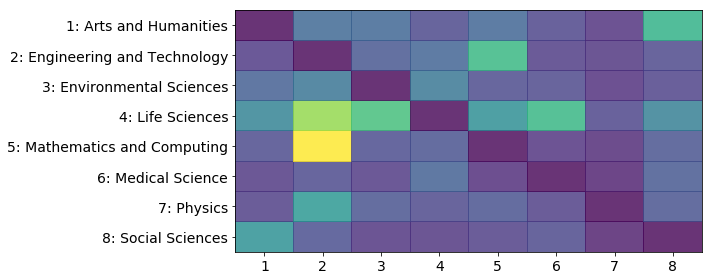

In [361]:

diag = []

for x in np.arange(len(disc_preds)):
    for y in np.arange(len(disc_preds)):
        if x==y:
            diag.append(disc_preds.iloc[x,y])
            
            disc_preds.iloc[x,y]=0 
            


#Predictions (flip order)
disc_preds_t = disc_preds.loc[disc_preds.columns[-1::-1],:]

#Convert to array
disc_preds_arr = np.array(disc_preds_t)

disc_preds_arr.swapaxes(1,0)
#np.fill_diagonal(disc_preds_arr,0)


#disc_preds_arr = np.array(disc_preds)

#np.fill_diagonal(disc_preds_arr,0)


fig,ax = plt.subplots(figsize=(10,4))

#disc_preds_arr_2 = disc_preds_arr.T

ax.pcolor(disc_preds_arr, cmap=plt.cm.viridis, alpha=0.8)

ax.set_yticks([x+0.5 for x in np.arange(len(disc_preds))])
ax.set_yticklabels([str(num)+": "+x for num,x in zip(range(1,9)[-1::-1],disc_preds.columns[-1::-1])],fontsize=14)

ax.set_xticks([x+0.5 for x in np.arange(len(disc_preds[-1::-1]))])
ax.set_xticklabels([x+1 for x in np.arange(len(disc_preds))],fontsize=14)

#ax.set_xticklabels(disc_preds.columns,rotation=90,fontsize=14)

#ax.set_title('Discipline overlap in the predictive model',fontsize=18)

plt.tight_layout()

plt.savefig('/Users/jmateosgarcia/Desktop/projects_2016/arloesiadur_new/gtr/reports/Papers/disc_matrix.pdf')
